In [85]:
import sys
import os

import spotipy
import json
import pprint
import pandas as pd
import configparser
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import spotipy.oauth2 as oauth2
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [86]:
#Authenticate with config file and spotipy client_id, client_secret, username, values

config = configparser.ConfigParser()
config.read('config_ernflerberg.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')
username = config.get('SPOTIFY', 'USERNAME')


auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
sp = spotipy.Spotify(auth=token)

In [87]:
def getTrivialInfo(playlistList):
    dfTrivialList=[]
    for playlist in playlistList:
        index=0
        dfTrivial = pd.DataFrame(columns=('SongName', 'SongId', 'SongArtist'), index=np.arange(0, len(playlist['tracks']['items'])))
        for item in playlist['tracks']['items']:
            track = item['track']
            dfTrivial.loc[index]=[track['name'], track['id'], track['artists'][0]['name']]
            index+=1
        dfTrivialList.append(dfTrivial)
    return dfTrivialList

In [88]:
def getSongList(dfTrivialList):
    songIdsList=[]
    for dfTrivial in dfTrivialList:
        songIds=list(dfTrivial['SongId'])
        songIdsList.append(songIds)
    return songIdsList

In [89]:
def getFeaturesList(dfTrivialList, songIdsList, columns=('SongName', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence', 'Instrumentalness','Tempo')):
    dfFeaturesList=[]
    for dfTrivial, songIds in zip(dfTrivialList, songIdsList):
        index=0
        audioFeatures = sp.audio_features(tracks=songIds)
        categories=columns[1:]
        dfFeatures = pd.DataFrame(columns=columns, index=np.arange(0, len(songIds)))
        for i, song in enumerate(audioFeatures):
            dfFeatures.loc[index]=[list(dfTrivial['SongName'])[i], song['danceability'], song['energy'], song['loudness'], song['speechiness'], song['acousticness'], song['valence'], song['instrumentalness'], song['tempo']]
            index+=1
        dfFeaturesList.append(dfFeatures)
    return dfFeaturesList

In [90]:
def getFeaturesToUse(dfFeaturesList, categories=['Danceability','Energy', 'Speechiness', 'Acousticness', 'Valence']):
    featuresToUseList=[]
    for dfFeatures in dfFeaturesList:
        features = dfFeatures[categories]
        featuresToUseList.append(features)
    return featuresToUseList

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import operator

In [92]:
def featurePreprocessing(song, categories=['Danceability','Energy', 'Speechiness', 'Acousticness', 'Valence']):
    return song[categories]

In [93]:
playlistDictionary={
                   "Liked": "3s3OCt230DDEIGX8xOY58A",  #like: spotify:user:ernflerberg:playlist:3s3OCt230DDEIGX8xOY58A
                   "Dislike": "7I2vgcXF2DBLsmC7EqahC0" #dislike: spotify:user:ernflerberg:playlist:7I2vgcXF2DBLsmC7EqahC0
                   }

In [94]:
LikedId=playlistDictionary["Liked"]
DislikeId=playlistDictionary["Dislike"]
spotifyUsername='ernflerberg'

likedplay=sp.user_playlist(spotifyUsername, playlist_id=LikedId)
dislikeplay=sp.user_playlist(spotifyUsername, playlist_id=DislikeId)

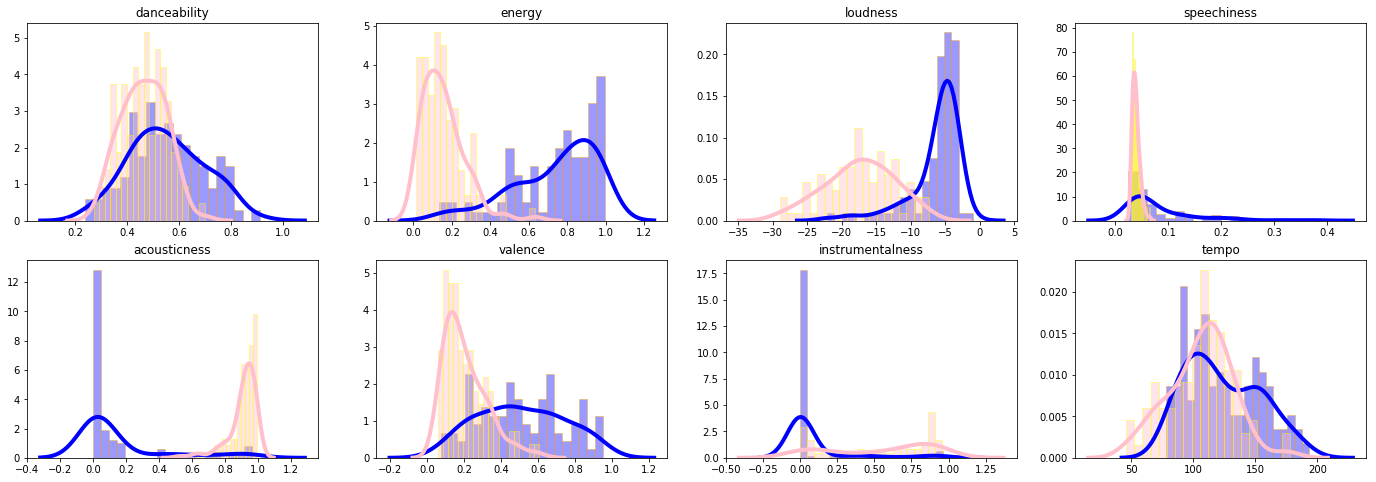

In [99]:
column=('songName', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'valence', 'instrumentalness','tempo')
playlistList=[likedplay, dislikeplay]
n_bins=20
fig, axs = plt.subplots(figsize=(24, 8), nrows=2, ncols=4)
axs=axs.flatten()
dfTrivialList=getTrivialInfo(playlistList)
songIdsList=getSongList(dfTrivialList)
songIds1=songIdsList[0]
songIds2=songIdsList[1]

audioFeatures1 = sp.audio_features(tracks=songIds1)
audioFeatures2 = sp.audio_features(tracks=songIds2)

for song1, song2 in zip(audioFeatures1, audioFeatures2):
    if song1 is None:
        audioFeatures1.remove(song1)
    if song2 is None:
        audioFeatures2.remove(song2)
            
index=0
for feature in column[1:]:
    ax=axs[index]
    ax.set_title(feature)
    featureListToPlot1 = []
    featureListToPlot2 = []

    for song1, song2 in zip(audioFeatures1, audioFeatures2):
        featureListToPlot1.append(song1[feature])
        featureListToPlot2.append(song2[feature])


    sns.distplot(featureListToPlot1, hist=True, bins=n_bins, color = 'blue', hist_kws={'edgecolor':'orange'}, kde_kws={'linewidth': 4}, ax=ax)
    sns.distplot(featureListToPlot2, hist=True, bins=n_bins, color = 'pink', hist_kws={'edgecolor':'yellow'}, kde_kws={'linewidth': 4}, ax=ax)
    index+=1

In [96]:
categories = column[1:]
tempoFeaturesTogether=[]
loudnessFeaturesTogether=[]

for song1, song2 in zip(audioFeatures1, audioFeatures2):
    tempoFeaturesTogether.append(song1['tempo'])
    tempoFeaturesTogether.append(song2['tempo'])

    loudnessFeaturesTogether.append(song1['loudness'])
    loudnessFeaturesTogether.append(song2['loudness'])
    
minimumTempo=min(tempoFeaturesTogether)
maximumTempo=max(tempoFeaturesTogether)
minimumLoudness=min(loudnessFeaturesTogether)
print(minimumLoudness)
maximumLoudness=max(loudnessFeaturesTogether)
print(maximumLoudness)

for song1, song2 in zip(audioFeatures1, audioFeatures2):
    song1['tempo']=(song1['tempo']-minimumTempo)/(maximumTempo-minimumTempo)
    song2['tempo']=(song2['tempo']-minimumTempo)/(maximumTempo-minimumTempo)

    song1['loudness']=(song1['loudness']-minimumLoudness)/(maximumLoudness-minimumLoudness)
    song2['loudness']=(song2['loudness']-minimumLoudness)/(maximumLoudness-minimumLoudness)


dfFeaturesList=[]
audioFeaturesList=[audioFeatures1, audioFeatures2]
for audioFeatures in audioFeaturesList:
    dfFeatures = pd.DataFrame(columns=categories, index=np.arange(0, len(audioFeatures)))
    for i, song in enumerate(audioFeatures[:99]):
        print(song['loudness'])
        dfFeatures.loc[i]=[song['danceability'], song['energy'], song['loudness'], song['speechiness'], song['acousticness'], song['valence'], song['instrumentalness'], song['tempo']]
    
    dfFeaturesList.append(dfFeatures)

for i in range(len(dfFeaturesList)):
    dfFeaturesList[i]=dfFeaturesList[i].mean()

dfFeaturesList=pd.concat(dfFeaturesList, axis=1)

-28.954
-0.943
0.9291706829459856
0.9226732355146192
0.8915783085216522
0.8662668237478134
0.8379565170825748
0.8662668237478134
0.8379565170825748
0.8227839063225162
0.8204633893827425
0.8204633893827425
0.8204633893827425
0.5975509621220235
0.8258184284745279
0.745599942879583
0.745599942879583
0.8783692120952483
0.6454250116025847
0.8783692120952483
0.8783692120952483
0.7697333190532291
0.863517903680697
0.9132126664524652
0.8857234657813003
0.9172824961622221
0.8754774909856842
0.5058369926100461
0.8596265752739995
0.6624540359144623
0.7190032487237157
0.45482132019563754
0.8229267073649639
0.8229267073649639
0.8841526543143766
0.8310663667844775
0.9036092963478634
0.823962014922709
0.8791546178287102
0.7465995501767163
0.8443468637321052
0.9088215343972011
0.8896861947092214
0.916925493556103
0.916925493556103
0.916925493556103
0.8443468637321052
0.9088215343972011
0.8319231730391632
0.8801899253864554
0.8957909392738567
0.9050016065117276
0.9036806968690873
0.6433186962264826
0.8

[0.5508383838383835, 0.7375959595959598, 0.8082932066010139, 0.08021515151515152, 0.15289978111111113, 0.5078727272727271, 0.0821211721212121, 0.5298305316807517]
[0.4623232323232326, 0.15430909090909095, 0.4148781377013142, 0.03982121212121212, 0.9087777777777772, 0.2036939393939394, 0.5366591818181818, 0.40583845914242395]


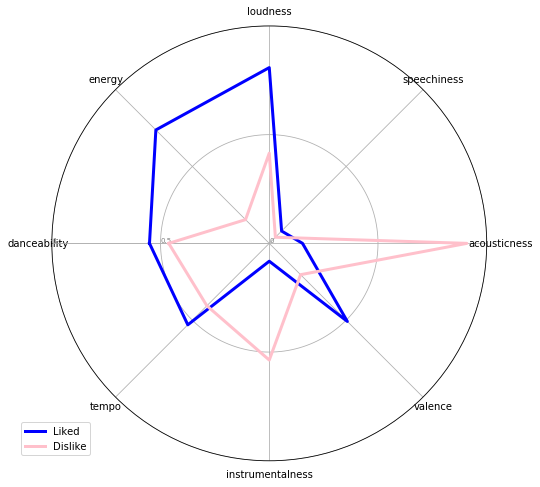

In [97]:
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi)
ax.set_theta_direction(-1)
 
plt.xticks(angles, categories)

ax.set_rlabel_position(0)
plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], color="grey", size=7)
plt.ylim(0, 1)
 

# Ind1
colors=['b', 'pink']
for i, key in enumerate(playlistDictionary.keys()):
    if i <4:
        values=list(dfFeaturesList[i])
        print(values)
        values += values[:1]
        ax.plot(angles, values, color=colors[i], linewidth=3, linestyle='solid', label=key)
 
# Add legend
plt.legend(bbox_to_anchor=(0.1, 0.1))